In [34]:
# conda install -c conda-forge wordcloud
# import nltk
# nltk.download("stopwords")
# !pip install pyspellchecker
# reference https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/

In [68]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
stop_words = list(set(stopwords.words('english')))

In [4]:
df_tr = pd.read_csv("train.csv", encoding='latin-1', index_col = False)

In [5]:
df_tr.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [6]:
df_tr.describe(include='all')

,ItemID,Sentiment,SentimentText
count,99989.000000,99989.000000,99989
unique,NaN,NaN,99989
top,NaN,NaN,@avvin skittles candy has a phrase they use to...
freq,NaN,NaN,1
mean,50005.110042,0.564632,NaN
std,28865.894393,0.495808,NaN
min,1.000000,0.000000,NaN
25%,25009.000000,0.000000,NaN
50%,50006.000000,1.000000,NaN
75%,75003.000000,1.000000,NaN


In [7]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ItemID           99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [8]:
train_pos = df_tr[df_tr["Sentiment"] == 1]
train_neg = df_tr[df_tr['Sentiment'] == 0]


In [70]:
def clean_text(each_text):
    clean_txt = each_text.lower().strip()
    clean_txt = re.sub('[^A-Za-z]',' ',clean_txt).strip().split()
    clean_txt = [" ".join(each for each in clean_txt if each not in stop_words)]
    clean_txt = [" ".join([word for word in clean_txt
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])]
    if clean_txt:
        return clean_txt[0]
    else: return ""

In [73]:
SentimentTextCleanedPos = train_pos['SentimentText'].apply(clean_text)
SentimentTextCleanedNeg = train_neg['SentimentText'].apply(clean_text)
SentimentTextCleanedNeg.head(10)

0                                        sad apl friend
1                               missed new moon trailer
3     omgaga im sooo im gunna cry dentist since supo...
4                                  think mi bf cheating
5                                            worry much
7                        sunny work tomorrow tv tonight
10                                  must think positive
12                                   weekend sucked far
13                            jb isnt showing australia
14                                         ok thats win
Name: SentimentText, dtype: object

Positive words


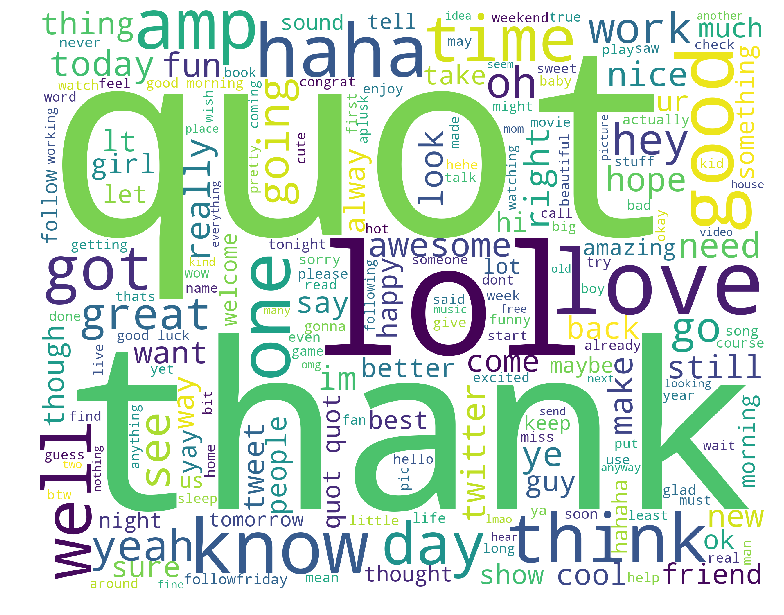

Negative words


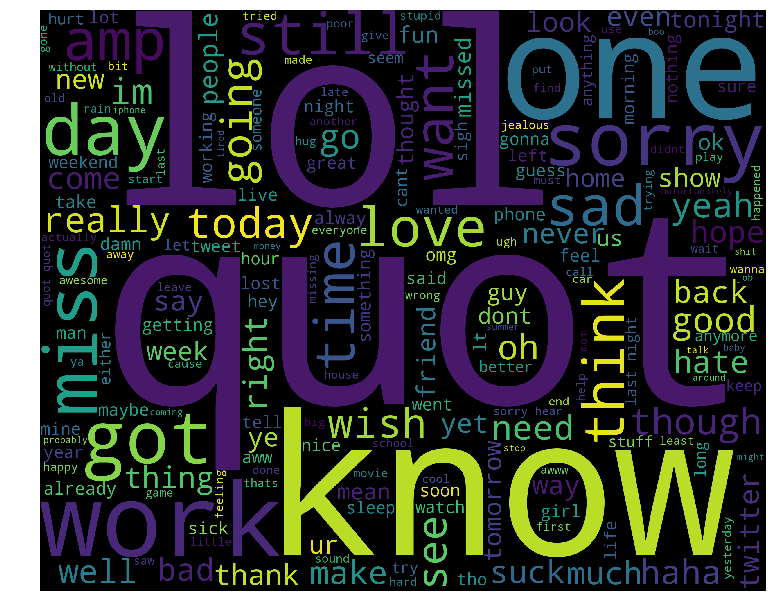

In [74]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(SentimentTextCleanedPos,'white')
print("Negative words")
wordcloud_draw(SentimentTextCleanedNeg)

In [81]:
X = df_tr['SentimentText'].apply(clean_text)
y = df_tr['Sentiment']
print(len(X), len(y))


99989 99989


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(66992,)
(32997,)
(66992,)
(32997,)


In [92]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_train = CountVectorizer()

In [93]:
X_train_vec = vectorizer_train.fit_transform(X_train)
X_train_vec

<66992x71020 sparse matrix of type '<class 'numpy.int64'>'
	with 477895 stored elements in Compressed Sparse Row format>

In [94]:
vectorizer_test = CountVectorizer(vocabulary=vectorizer_train.vocabulary_)
X_test_vec = vectorizer_test.fit_transform(X_test)
X_test_vec

<32997x71020 sparse matrix of type '<class 'numpy.int64'>'
	with 213201 stored elements in Compressed Sparse Row format>

In [95]:
from sklearn.naive_bayes import MultinomialNB

mnnb = MultinomialNB()

In [96]:
%time mnnb.fit(X_train_vec, y_train)

Wall time: 27.3 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [97]:
y_predicted = mnnb.predict(X_test_vec)

In [103]:
from sklearn import metrics
print("Accuracy :: ",metrics.accuracy_score(y_test, y_predicted))
print("Precision :: ",metrics.precision_score(y_test, y_predicted))
print("Recall :: ",metrics.recall_score(y_test, y_predicted))

Accuracy ::  0.7428251053126042
Precision ::  0.7530621503099955
Recall ::  0.8063906730717332


In [105]:
print(y_test.value_counts())
print("[[TN,FP],\n[FN,TP]]")
metrics.confusion_matrix(y_test, y_predicted)

1    18527
0    14470
Name: Sentiment, dtype: int64
[[TN,FP],
[FN,TP]]


array([[ 9571,  4899],
       [ 3587, 14940]], dtype=int64)

In [108]:
y_pred_prob = mnnb.predict_proba(X_test_vec)[:, 1]
y_pred_prob

array([0.21685086, 0.99927539, 0.00785454, ..., 0.07453041, 0.36689268,
       0.26414131])

In [109]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.8092292300271603

In [110]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

In [111]:
%time log_reg.fit(X_train_vec, y_train)

C:\Users\C5287142\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 2.54 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [114]:
y_pred_lreg = log_reg.predict(X_test_vec) 
metrics.accuracy_score(y_test, y_pred_lreg)

0.7446737582204442

In [116]:
y_pred_lreg_prob = log_reg.predict_proba(X_test_vec)[:, 1]
y_pred_lreg_prob

array([0.5038905 , 0.9948715 , 0.0119743 , ..., 0.236432  , 0.4016197 ,
       0.10989717])

In [118]:
metrics.roc_auc_score(y_test, y_pred_lreg_prob)

0.8153652177406411